In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import random

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

# 180

In [2]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X = X.drop(["max_consecutive_highwind_days", "Densità", "count_highwind", "type_rural", "type_urban", "Quota"], axis=1)

In [3]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
random.seed(2024)

idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [6]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),

    "y": Y_obs['Count_180'],
    "P": X_obs.shape[1],

    "nyears": 13,
    "nstations": 45,
    "nmonths": 7,

    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,

    "X": X_obs,
    "X_miss": X_miss,

    "phi": phi,
    "distances": distances,

    "month": months_obs,
    "month_miss": months_miss
}

In [7]:
bin_logit_var = FetchModel('final').compile()

11:09:48 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\AAB4F7~1.23-\BAYESI~1\BAYESI~1\main\Modello\stan\final.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\A.A. 23-24\Bayesian statistics\Bayesian_Project\main\Modello\stan\final.exe
11:10:50 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\A.A. 23-24\Bayesian statistics\Bayesian_Project\main\Modello\stan\final.exe


In [8]:
bin_logit_var_180 = bin_logit_var.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_logit_var_180 = az.from_cmdstanpy(bin_logit_var_180)

11:10:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:16:45 - cmdstanpy - INFO - CmdStan done processing.


11:16:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 4 divergent transitions (0.4%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [9]:
post_pred = PostPred(posterior_bin_logit_var_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

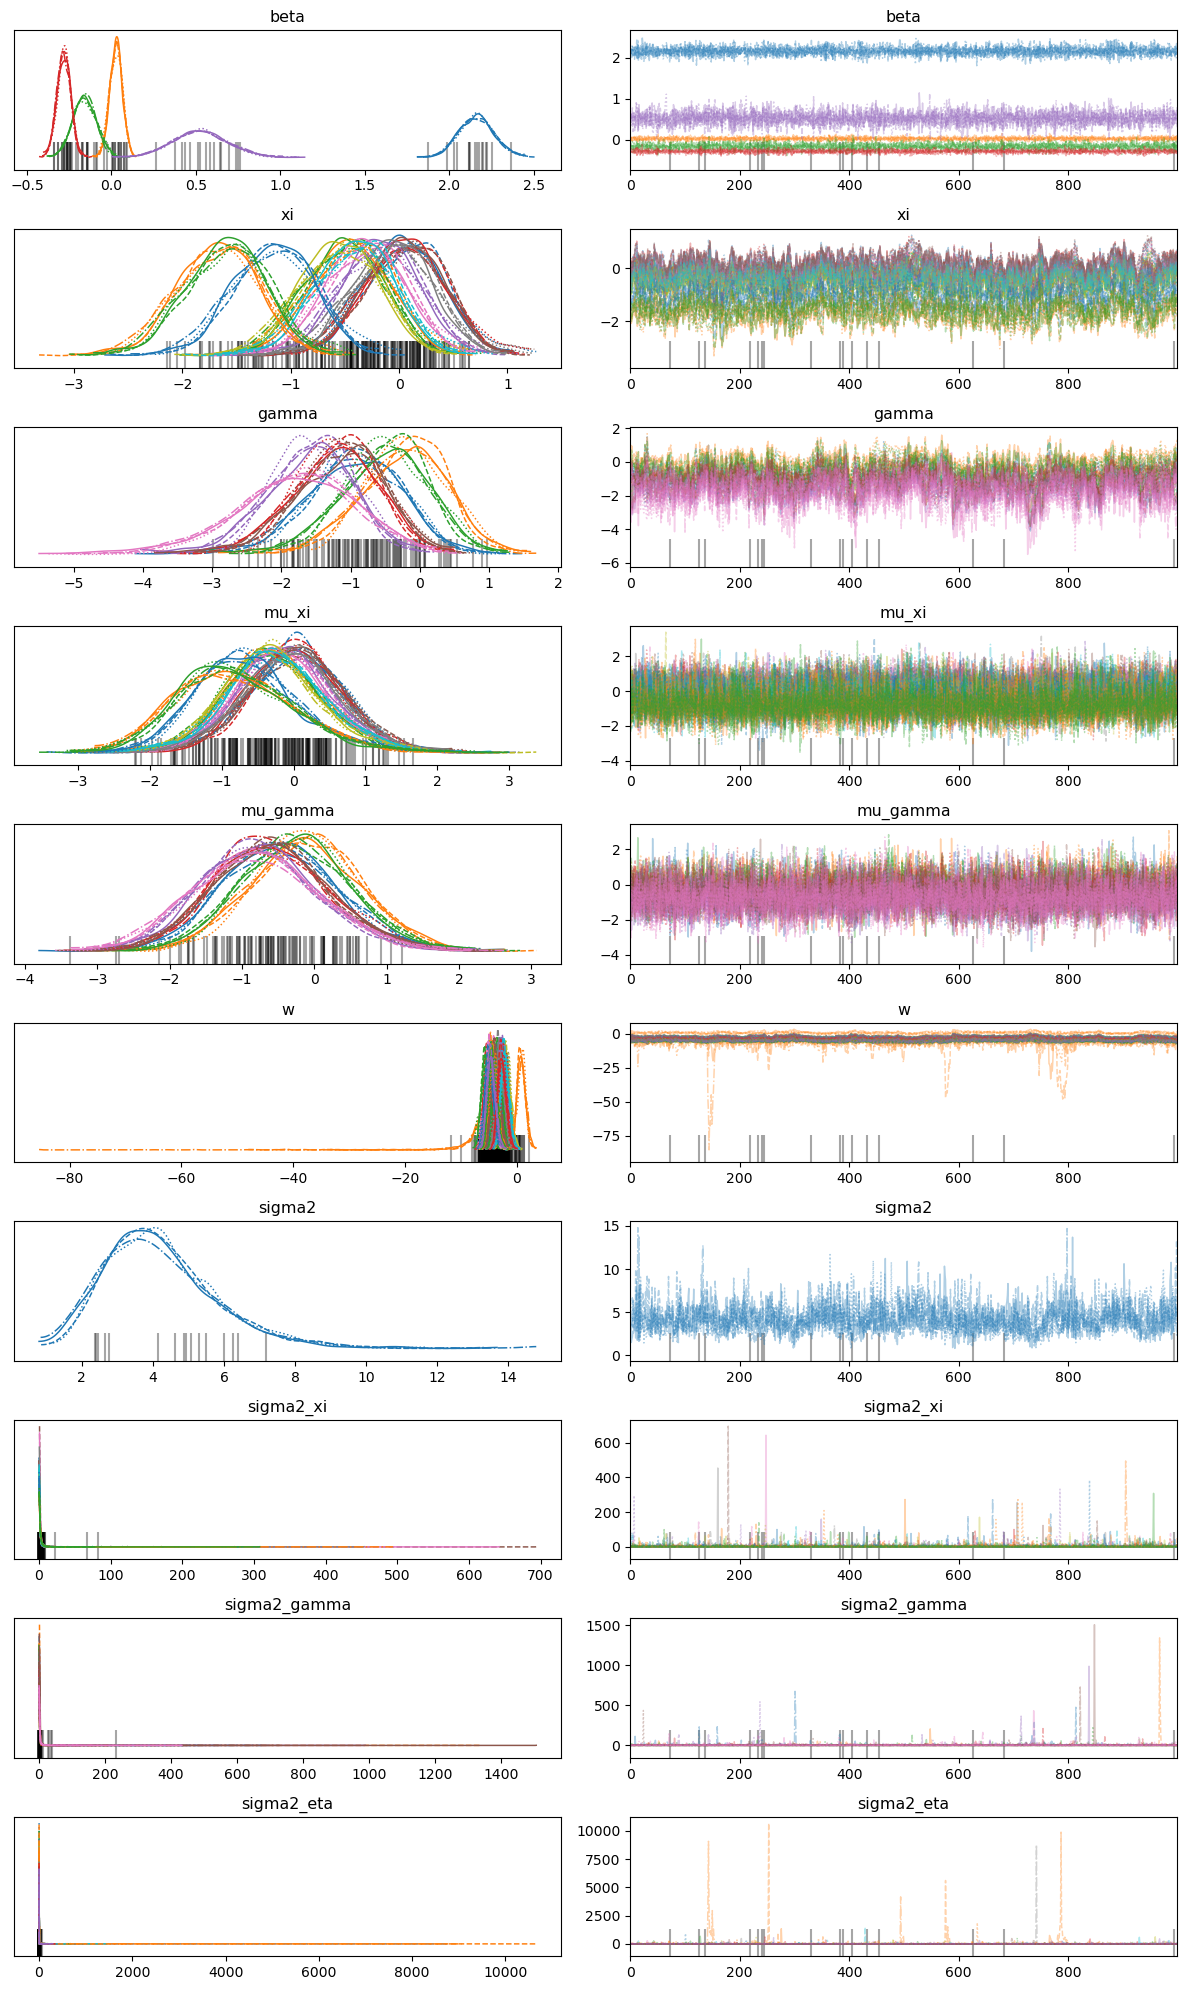

In [10]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'mu_xi', 'mu_gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma', 'sigma2_eta'])
plt.tight_layout()
plt.show()

In [11]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2648.11    75.62
p_waic      123.12        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2649.07    75.67
p_loo      124.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2660   99.8%
 (0.5, 0.7]   (ok)          6    0.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [12]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [13]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 131

The total number of outliers in the test set is: 37

The MSE is: 2.0536370798319328

The MAE is: 0.6897321428571429

The MAD is: 0.0

The MSE in the test set is: 2.195490367775832

The MAE in the test set is: 0.73861646234676

The MAD in the test set is: 0.0

The percentage of observations inside the CI is: 0.9655987394957983

The percentage of observations inside the CI of the test is: 0.967600700525394



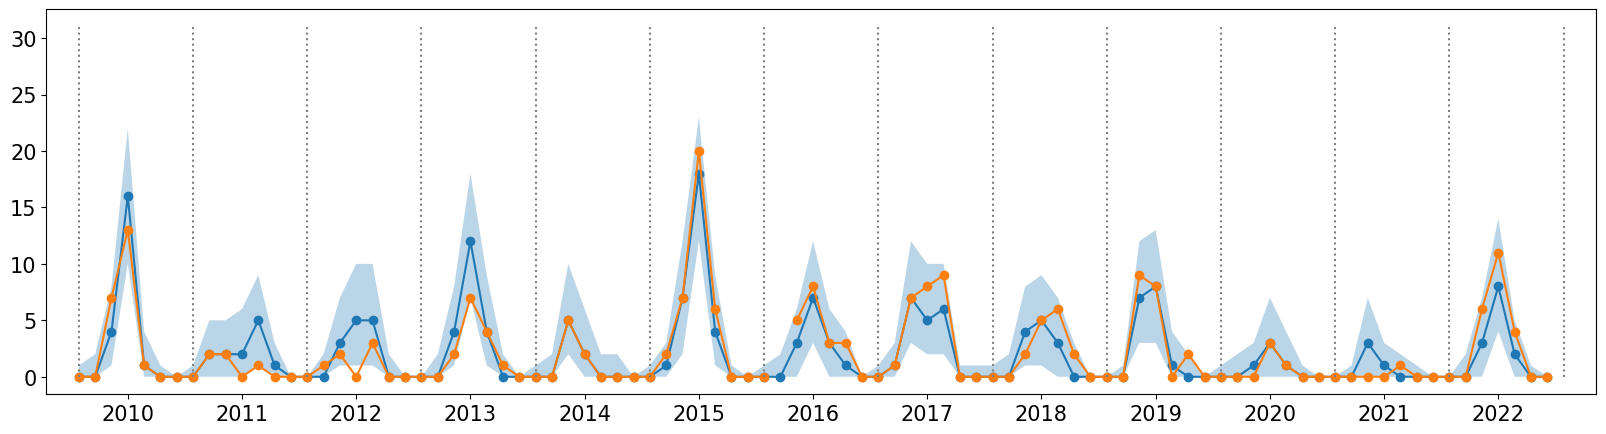

In [14]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(20, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(3,len(xx),7)], np.arange(2010,2023), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(xx[0]-2, xx[-1]+3)
plt.vlines(xx[np.arange(0,len(xx),7)], ymin=0, ymax=31, colors='gray', linestyles='dotted')
plt.vlines(xx[-1]+1, ymin=0, ymax=31, colors='gray', linestyles='dotted')
plt.savefig('sample_180.pdf', bbox_inches='tight')
plt.show()

# 120

In [15]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X = X.drop(["max_consecutive_highwind_days", "Densità", "count_highwind", "type_rural", "type_urban", "Quota"], axis=1)

In [16]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
random.seed(2024)

idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [26]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [17]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [27]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),

    "y": Y_obs['Count_120'],
    "P": X_obs.shape[1],

    "nyears": 13,
    "nstations": 45,
    "nmonths": 7,

    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,

    "X": X_obs,
    "X_miss": X_miss,

    "phi": phi,
    "distances": distances,

    "month": months_obs,
    "month_miss": months_miss
}

In [19]:
bin_logit_var = FetchModel('final').compile()

In [28]:
bin_logit_var_120 = bin_logit_var.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_logit_var_120 = az.from_cmdstanpy(bin_logit_var_120)

11:22:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:28:51 - cmdstanpy - INFO - CmdStan done processing.


11:28:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [29]:
post_pred = PostPred(posterior_bin_logit_var_120, Y['Count_120'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

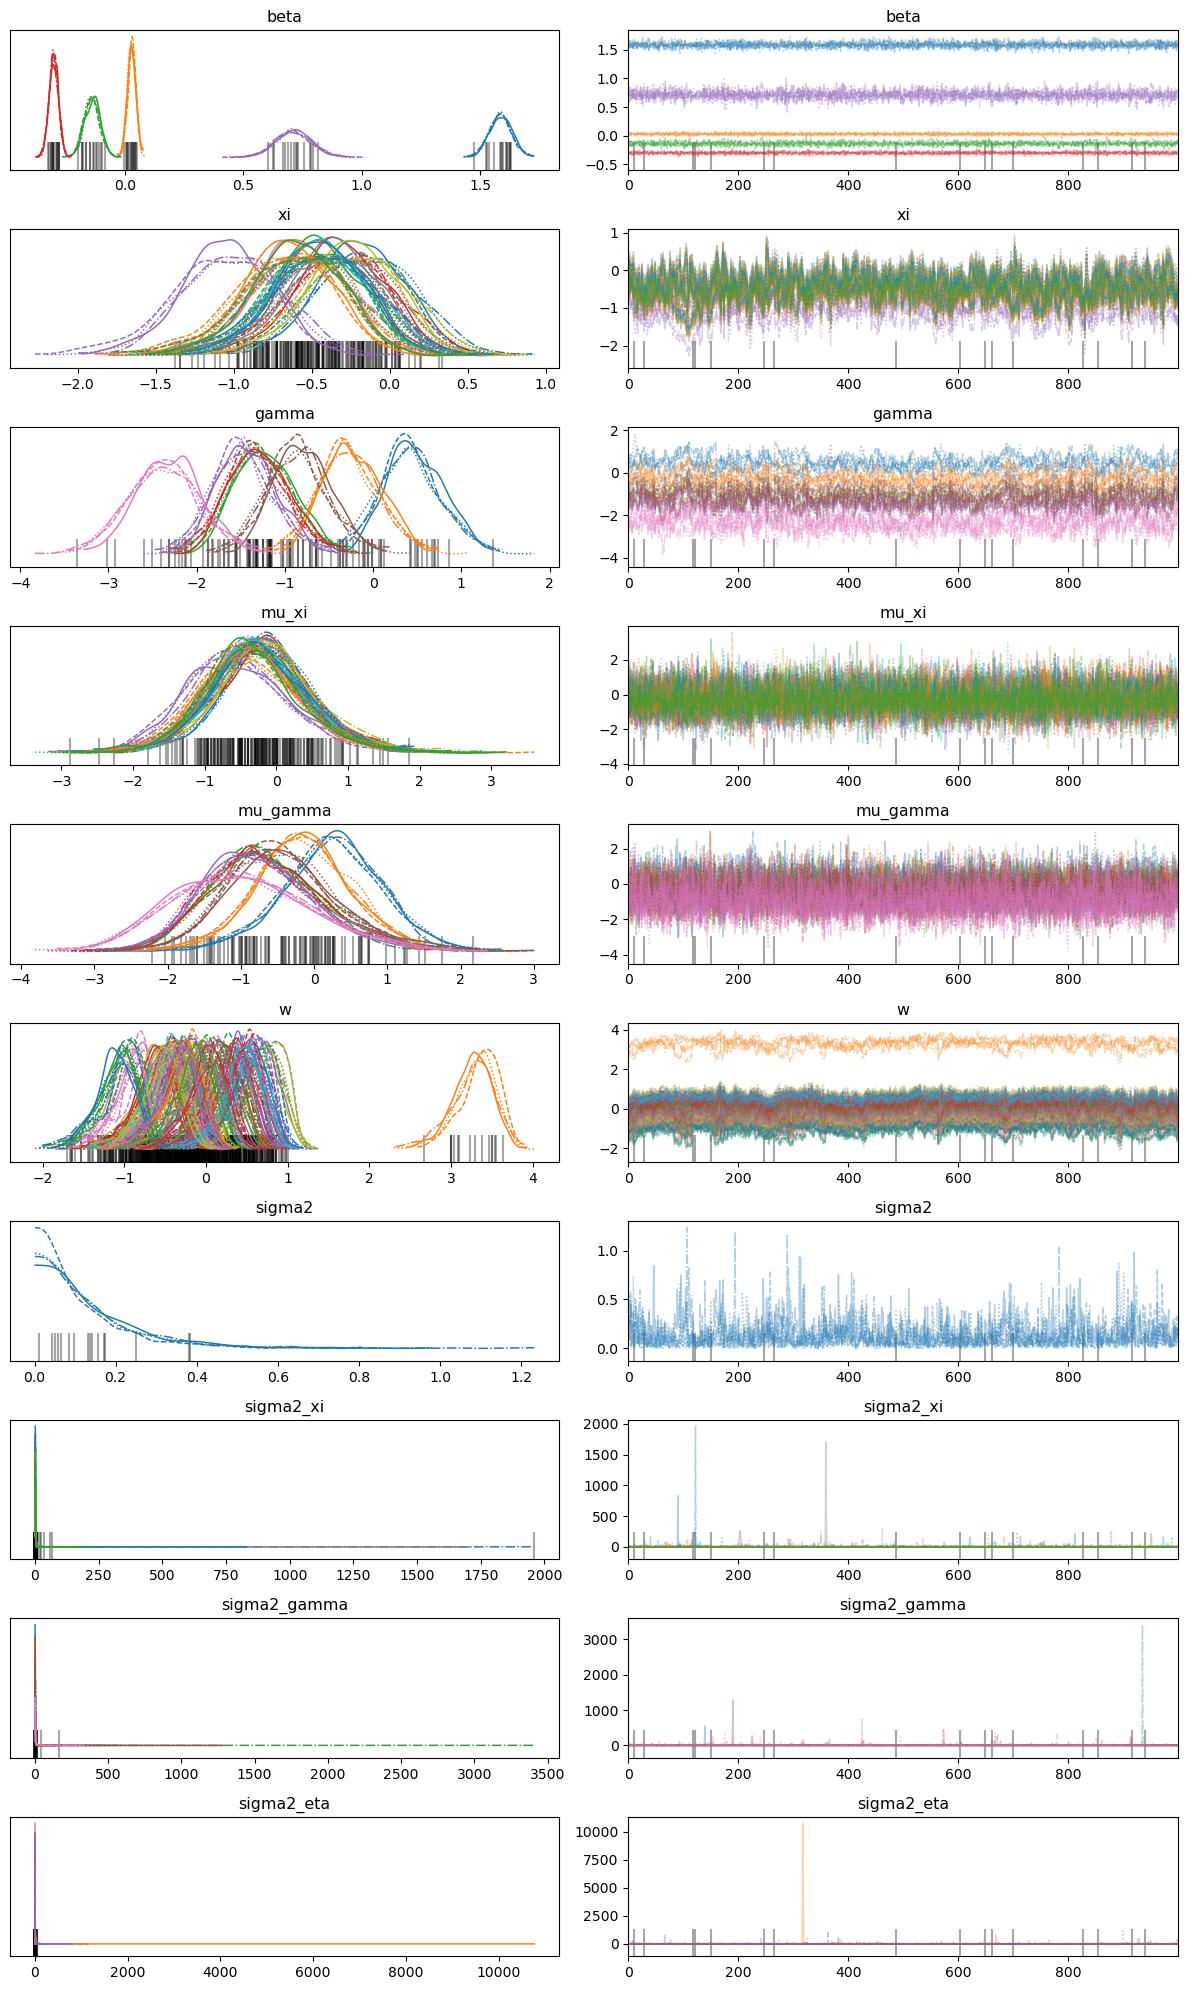

In [30]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'mu_xi', 'mu_gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma', 'sigma2_eta'])
plt.tight_layout()
plt.show()

In [31]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6723.31   103.18
p_waic      157.89        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6723.76   103.20
p_loo      158.34        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2688  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [32]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [33]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 473

The total number of outliers in the test set is: 156

The MSE is: 10.3326171875

The MAE is: 2.299088541666667

The MAD is: 2.0

The MSE in the test set is: 10.904296875

The MAE in the test set is: 2.3875868055555554

The MAD in the test set is: 2.0

The percentage of observations inside the CI is: 0.8768229166666667

The percentage of observations inside the CI of the test is: 0.8645833333333334



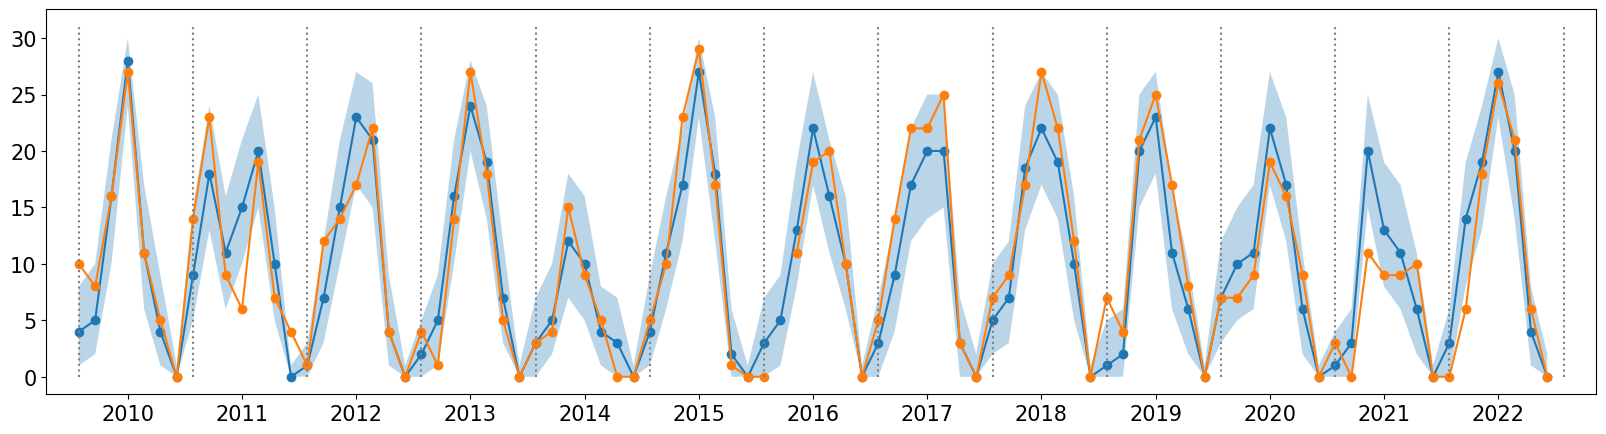

In [34]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(20, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(3,len(xx),7)], np.arange(2010,2023), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(xx[0]-2, xx[-1]+3)
plt.vlines(xx[np.arange(0,len(xx),7)], ymin=0, ymax=31, colors='gray', linestyles='dotted')
plt.vlines(xx[-1]+1, ymin=0, ymax=31, colors='gray', linestyles='dotted')
plt.savefig('sample_120.pdf', bbox_inches='tight')
plt.show()

# Confronto CI Beta

In [35]:
X.columns

Index(['mean_temperature', 'mean_precipitation_sum',
       'mean_precipitation_hours', 'mean_windspeed_10m_max',
       'mean_radiation_sum'],
      dtype='object')

In [36]:
nicer_names = {
    'mean_temperature': 'Temperature',
    'mean_precipitation_sum': 'Precipitation Tot',
    'mean_precipitation_hours': 'Precipitation Hours',
    'mean_windspeed_10m_max': 'Wind Speed',
    'mean_radiation_sum': 'Radiation'
}

In [42]:
covariates_or = ["mean_temperature", "mean_precipitation_sum", "mean_precipitation_hours", "mean_windspeed_10m_max", "mean_radiation_sum"]
covariates_idx = [X.columns.get_loc(cov) for cov in covariates_or]
betas_180 = posterior_bin_logit_var_180.posterior['beta'].stack(sample=("chain", "draw"))
betas_120 = posterior_bin_logit_var_120.posterior['beta'].stack(sample=("chain", "draw"))
betas_180 = betas_180[covariates_idx]
betas_120 = betas_120[covariates_idx]
covariates = [nicer_names[cov] for cov in covariates_or]

In [43]:
covariates = covariates[::-1]
betas_180 = betas_180[::-1]
betas_120 = betas_120[::-1]

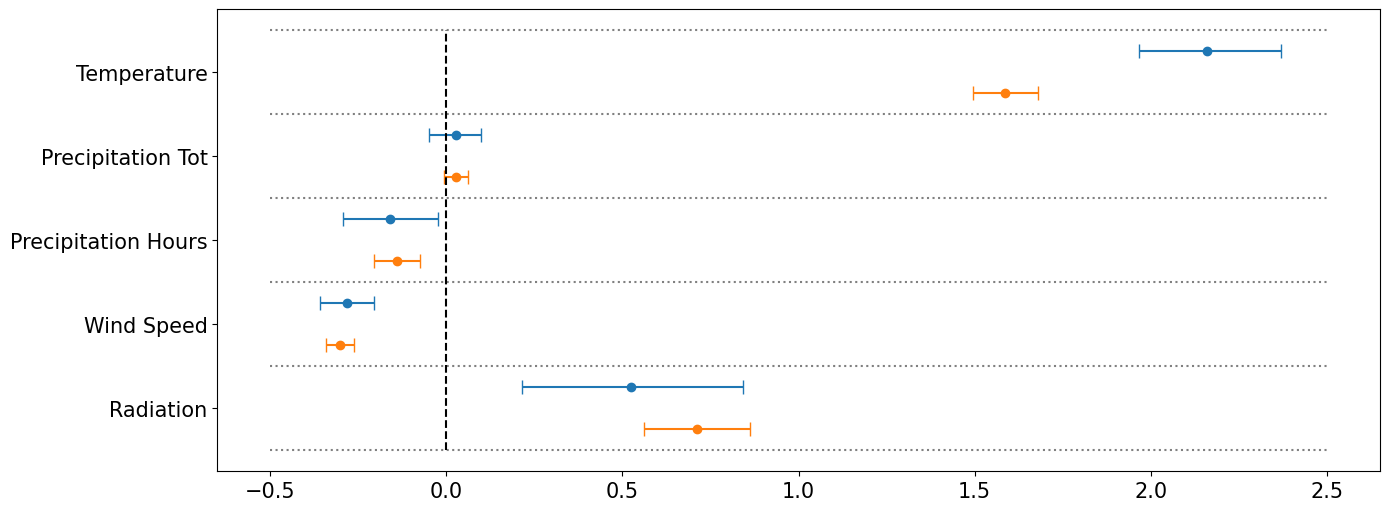

In [44]:
plt.figure(figsize=(15, 6))
plt.errorbar(betas_180.median(dim='sample'), np.arange(2, len(covariates)*4 - 1, 4), xerr=[betas_180.median(dim='sample') - betas_180.quantile(0.025, dim='sample'), betas_180.quantile(0.975, dim='sample') - betas_180.median(dim='sample')], fmt='o', label='180', capsize=5)
plt.errorbar(betas_120.median(dim='sample'), np.arange(0, len(covariates)*4 - 3, 4), xerr=[betas_120.median(dim='sample') - betas_120.quantile(0.025, dim='sample'), betas_120.quantile(0.975, dim='sample') - betas_120.median(dim='sample')], fmt='o', label='120', capsize=5)
plt.yticks(np.arange(1, len(covariates)*4 - 2, 4), covariates, fontsize=15)
plt.xticks(fontsize=15)
plt.hlines(np.arange(-1, len(covariates)*4, 4), xmin=-0.5, xmax=2.5, colors='gray', linestyles='dotted')
plt.vlines(0, ymin=-1, ymax=len(covariates)*4-1, colors='black', linestyles='--')
plt.savefig('beta_CI.pdf', bbox_inches='tight')
plt.show()

In [45]:
xi_180 = posterior_bin_logit_var_180.posterior['xi'].stack(sample=("chain", "draw"))
xi_120 = posterior_bin_logit_var_120.posterior['xi'].stack(sample=("chain", "draw"))
years_plot = np.arange(2010, 2023)

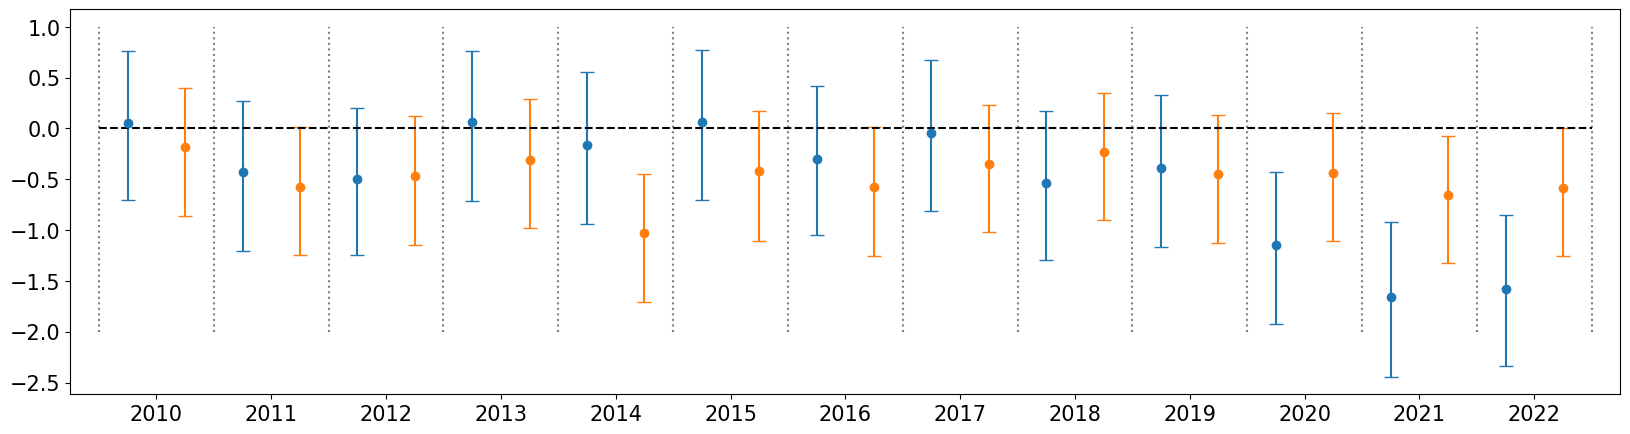

In [46]:
plt.figure(figsize=(20, 5))
plt.errorbar(np.arange(0, len(years_plot)*4 - 3, 4), xi_180.median(dim='sample'), yerr=[xi_180.median(dim='sample') - xi_180.quantile(0.025, dim='sample'), xi_180.quantile(0.975, dim='sample') - xi_180.median(dim='sample')], fmt='o', label='180', capsize=5)
plt.errorbar(np.arange(2, len(years_plot)*4 - 1, 4), xi_120.median(dim='sample'), yerr=[xi_120.median(dim='sample') - xi_120.quantile(0.025, dim='sample'), xi_120.quantile(0.975, dim='sample') - xi_120.median(dim='sample')], fmt='o', label='120', capsize=5)
plt.xticks(np.arange(1, len(years_plot)*4 - 2, 4), years_plot, fontsize=15)
plt.yticks(fontsize=15)
plt.vlines(np.arange(-1, len(years_plot)*4, 4), ymin=-2, ymax=1, colors='gray', linestyles='dotted')
plt.hlines(0, xmin=-1, xmax=len(years_plot)*4-1, colors='black', linestyles='--')
plt.xlim(-2, len(years_plot)*4)
plt.savefig('xi_CI.pdf', bbox_inches='tight')
plt.show()